Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

## Importing Skin Cancer Data

### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path("/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Test")

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


## Load using keras.preprocessing
### Let's load these images off disk using the helpful image_dataset_from_directory utility.

#### Create a dataset
#### Define some parameters for the loader:

In [7]:
batch_size = 32
img_height = 180
img_width = 180

#### Use 80% of the images for training, and 20% for validation.

In [8]:


## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  labels='inferred',
  batch_size=batch_size,
  image_size=(img_height, img_width),
  seed=123,
  validation_split=0.2,
  subset='training')

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [9]:

## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  labels='inferred',
  batch_size=batch_size,
  image_size=(img_height, img_width),
  seed=123,
  validation_split=0.2,
  subset='validation')

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [10]:

# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data

#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

In [11]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,20))
for images, labels in train_ds.take(1):
  print(len(images))
  print(len(labels))
  for i in range(32):
    ax = plt.subplot(8, 4, i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### your code goes here, you can use training or validation data to visualize

Output hidden; open in https://colab.research.google.com to view.

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

Dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch.

Dataset.prefetch() overlaps data preprocessing and model execution while training.

AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

:## Create the model

#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use layers.experimental.preprocessing.Rescaling to normalize pixel values between (0,1). The RGB channel values are in the [0, 255] range. This is not ideal for a neural network. Here, it is good to standardize values to be in the [0, 1]

In [13]:
### Your code goes here
num_classes = 9
model = Sequential([
  layers.experimental.preprocessing.Rescaling(1.0/255, input_shape=(img_height, img_width, 3)),

  #2D convolution layer (e.g. spatial convolution over images).
  layers.Conv2D(16, 3, padding='same', activation='relu'),

  #sliding over the feature map and extract tiles of a specified size.
  #downsamples the input along its spatial dimensions (height and width) by taking the maximum value over an input window (of size defined by pool_size) for each channel of the input.
  layers.MaxPooling2D(),

  #2D convolution layer.
  layers.Conv2D(32, 3, padding='same', activation='relu'),

  layers.MaxPooling2D(),

  layers.Conv2D(64, 3, padding='same', activation='relu'),

  layers.MaxPooling2D(),

  #Flatting =  converting into 1D feature vector. Flattens the structure to create a single long feature vector
  layers.Flatten(),

  #fully connected layer (Dense Layer)
  #A hidden layer in which each node is connected to every node in the subsequent hidden layer
  layers.Dense(128, activation='relu'),
  
  #Dense layer is the only actual network layer feeding alll outputs from previous layer to all its' neurons implementing the operation: output = activation(dot(input, kernel)). its representing a matrix vector multiplication.
  layers.Dense(num_classes)                    
])


### Compile the model

#### Choose an appropirate optimiser and loss function for model training

In [14]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [15]:
# View the summary of all layers
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 45, 45, 64)       

### Train the model

In [16]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 330s 6s/step - loss: 2.0266 - accuracy: 0.2712 - val_loss: 1.8016 - val_accuracy: 0.3400
Epoch 2/20
56/56 [==============================] - 67s 1s/step - loss: 1.7535 - accuracy: 0.3677 - val_loss: 1.5730 - val_accuracy: 0.4743
Epoch 3/20
56/56 [==============================] - 66s 1s/step - loss: 1.4993 - accuracy: 0.4905 - val_loss: 1.4223 - val_accuracy: 0.5213
Epoch 4/20
56/56 [==============================] - 62s 1s/step - loss: 1.3939 - accuracy: 0.5246 - val_loss: 1.4623 - val_accuracy: 0.5101
Epoch 5/20
56/56 [==============================] - 66s 1s/step - loss: 1.3230 - accuracy: 0.5296 - val_loss: 1.4030 - val_accuracy: 0.5123
Epoch 6/20
56/56 [==============================] - 67s 1s/step - loss: 1.2260 - accuracy: 0.5781 - val_loss: 1.3404 - val_accuracy: 0.5324
Epoch 7/20
56/56 [==============================] - 63s 1s/step - loss: 1.1410 - accuracy: 0.5893 - val_loss: 1.4268 - val_accuracy: 0.5414
Epoch 8/20
56/56 [=

### Visualizing training results

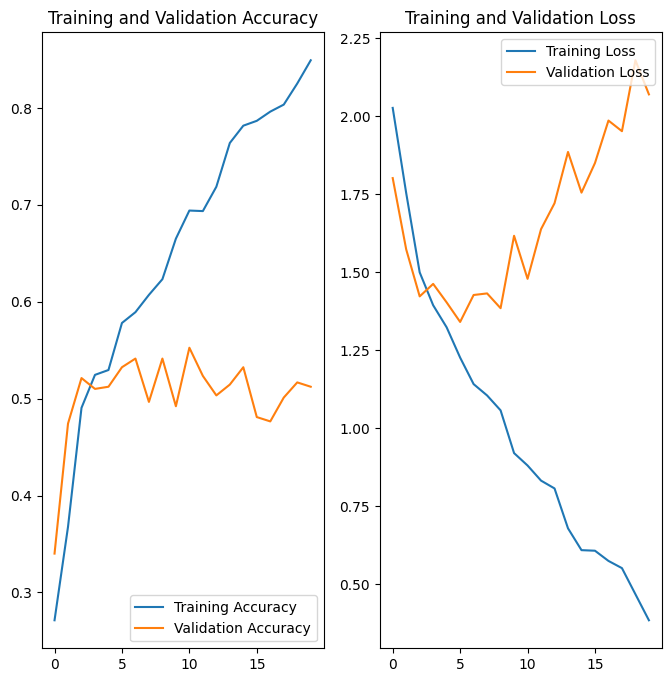

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

## Write your findings here

In [18]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here
data_augmentation = keras.Sequential(
    [
     layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical",
                                                  input_shape=(img_height,
                                                               img_width,
                                                               3)),
     layers.experimental.preprocessing.RandomRotation(0.4),
     layers.experimental.preprocessing.RandomZoom(0.5),
     layers.experimental.preprocessing.RandomContrast(0.5),
     layers.experimental.preprocessing.RandomCrop(img_height, img_width),
     layers.experimental.preprocessing.RandomTranslation(1,.5,fill_mode="reflect",interpolation="bilinear",seed=None,fill_value=0.0),
    ]
)

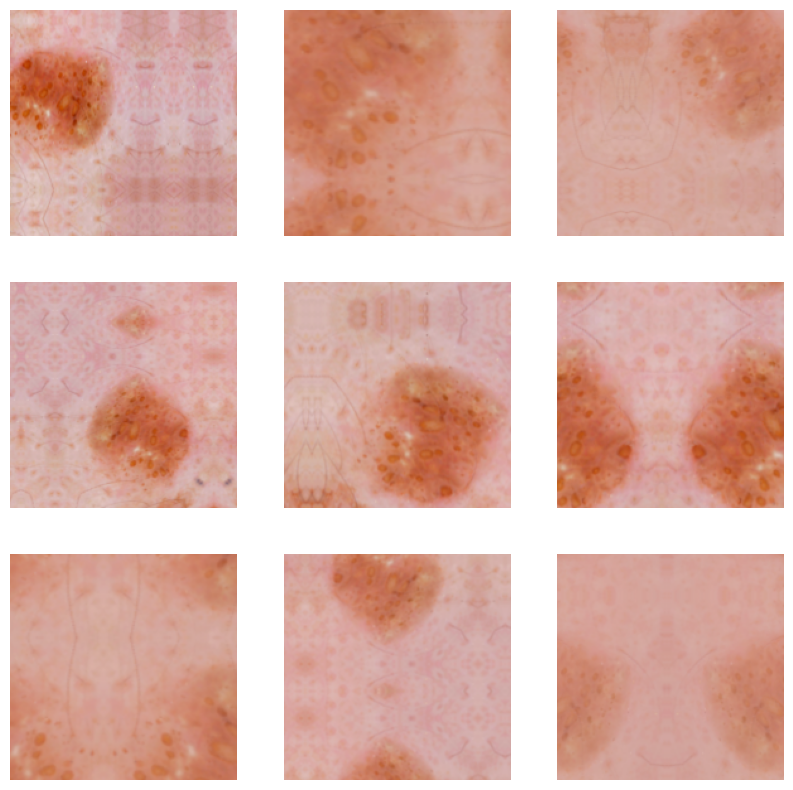

In [19]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
plt.figure(figsize=(10,10))
for images, _ in train_ds.take(1):  
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Todo:
    
### Create the model, compile and train the model

In [20]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here
num_classes = 9
model = Sequential([
  data_augmentation,

  layers.experimental.preprocessing.Rescaling(1.0/255, input_shape=(img_height, img_width, 3)),

  #2D convolution layer (e.g. spatial convolution over images).
  layers.Conv2D(16, 3, padding='same', activation='relu'),

  #sliding over the feature map and extract tiles of a specified size.
  #downsamples the input along its spatial dimensions (height and width) by taking the maximum value over an input window (of size defined by pool_size) for each channel of the input.
  layers.MaxPooling2D(),
  

  #2D convolution layer.
  layers.Conv2D(32, 3, padding='same', activation='relu'),

  layers.MaxPooling2D(),

  layers.Conv2D(64, 3, padding='same', activation='relu'),

  layers.MaxPooling2D(),

  layers.Dropout(0.2),
  #Flatting =  converting into 1D feature vector. Flattens the structure to create a single long feature vector
  layers.Flatten(),

  #fully connected layer (Dense Layer)
  #A hidden layer in which each node is connected to every node in the subsequent hidden layer
  layers.Dense(128, activation='relu'),

  #Dense layer is the only actual network layer feeding alll outputs from previous layer to all its' neurons implementing the operation: output = activation(dot(input, kernel)). its representing a matrix vector multiplication.
  layers.Dense(num_classes) 
                  
])





### Compiling the model

In [21]:
## Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [22]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

### Training the model

In [23]:
## Your code goes here, note: train your model for 20 epochs
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 76s 1s/step - loss: 2.0982 - accuracy: 0.2171 - val_loss: 1.8629 - val_accuracy: 0.2841
Epoch 2/20
56/56 [==============================] - 74s 1s/step - loss: 1.8525 - accuracy: 0.3242 - val_loss: 1.7736 - val_accuracy: 0.3535
Epoch 3/20
56/56 [==============================] - 75s 1s/step - loss: 1.7560 - accuracy: 0.3499 - val_loss: 1.6989 - val_accuracy: 0.3445
Epoch 4/20
56/56 [==============================] - 78s 1s/step - loss: 1.6811 - accuracy: 0.3700 - val_loss: 1.7435 - val_accuracy: 0.3490
Epoch 5/20
56/56 [==============================] - 78s 1s/step - loss: 1.7564 - accuracy: 0.3493 - val_loss: 1.6800 - val_accuracy: 0.3579
Epoch 6/20
56/56 [==============================] - 78s 1s/step - loss: 1.6625 - accuracy: 0.3689 - val_loss: 1.6205 - val_accuracy: 0.3669
Epoch 7/20
56/56 [==============================] - 73s 1s/step - loss: 1.6548 - accuracy: 0.3783 - val_loss: 1.7024 - val_accuracy: 0.3960
Epoch 8/20
56/56 [==

### Visualizing the results

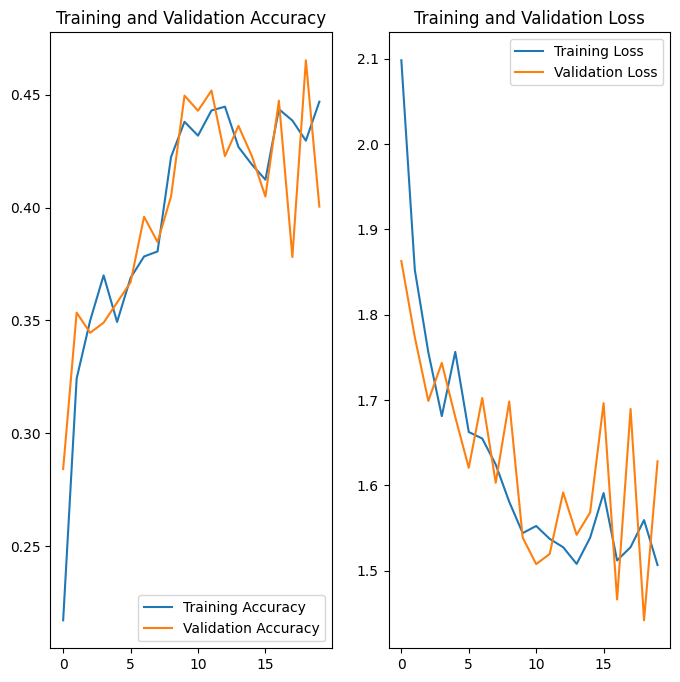

14/14 [==============================] - 7s 369ms/step - loss: 1.6282 - accuracy: 0.4004
Accuracy:  0.4068080484867096
Validation Accuracy:  0.40044742822647095
Loss:  1.591514229774475
Validation Loss 1.6281911134719849


In [36]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

#### Todo: Find the distribution of classes in the training dataset.

#### Context: Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [37]:
## Your code goes here.
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
len(path_list)

2239

In [38]:
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
len(lesion_list)

2239

In [39]:
dataframe_dict_original = dict(zip(path_list, lesion_list))

In [40]:
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/content/gdrive/MyDrive/Skin cancer ISIC The I...,actinic keratosis
1,/content/gdrive/MyDrive/Skin cancer ISIC The I...,actinic keratosis
2,/content/gdrive/MyDrive/Skin cancer ISIC The I...,actinic keratosis
3,/content/gdrive/MyDrive/Skin cancer ISIC The I...,actinic keratosis
4,/content/gdrive/MyDrive/Skin cancer ISIC The I...,actinic keratosis
...,...,...
2234,/content/gdrive/MyDrive/Skin cancer ISIC The I...,vascular lesion
2235,/content/gdrive/MyDrive/Skin cancer ISIC The I...,vascular lesion
2236,/content/gdrive/MyDrive/Skin cancer ISIC The I...,vascular lesion
2237,/content/gdrive/MyDrive/Skin cancer ISIC The I...,vascular lesion


<Figure size 1000x1000 with 0 Axes>

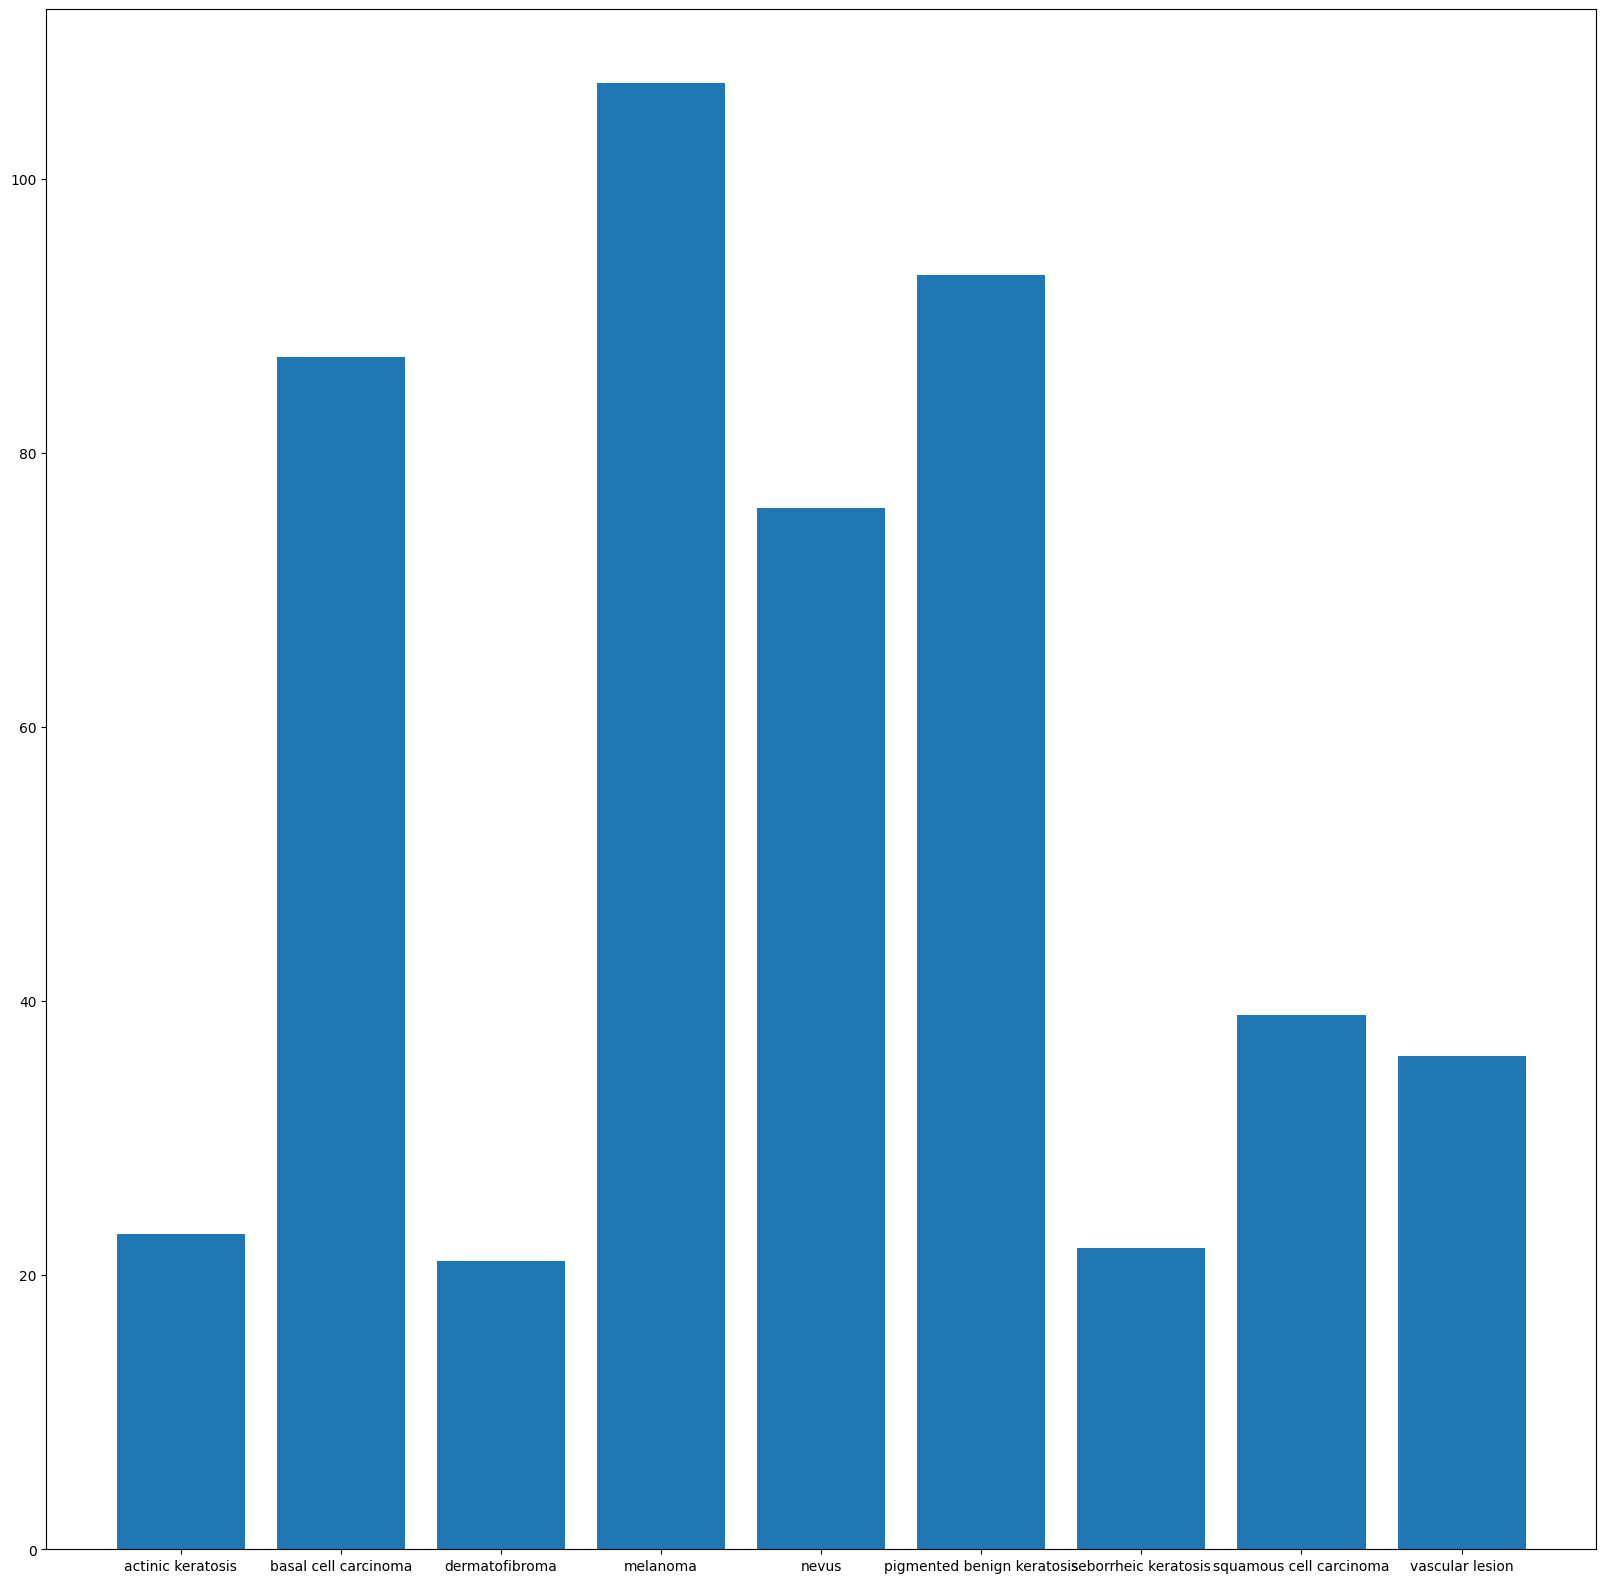

In [44]:
import matplotlib.pyplot as plt
data = dict()

for i in class_names:
  data[i] = []

plt.figure(figsize=(10, 10))
for images, labels in train_ds:
  for i in range(9):
    data[class_names[labels[i]]].append(images[i].numpy().astype("uint8"))

for i in data:
  data[i] = len(data[i]) 

f = plt.figure()
f.set_figwidth(20)
f.set_figheight(20)

plt.bar(range(len(data)), list(data.values()), align='center')
plt.xticks(range(len(data)), list(data.keys()))
plt.show()

#### Todo: Write your findings here:
- Which class has the least number of samples?
- Which classes dominate the data in terms proportionate number of samples?

#### Todo: Rectify the class imbalance

#### Context: You can use a python package known as Augmentor (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [45]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use Augmentor, the following general procedure is followed:

1. Instantiate a Pipeline object pointing to a directory containing your initial image data set.
2. Define a number of operations to perform on this data set using your Pipeline object.
3. Execute these operations by calling the Pipeline’s sample() method.

In [47]:
path_to_training_dataset="/content/gdrive/MyDrive/CNN/Skin_Data_Store/Train/"
# data_dir_train = pathlib.Path(root_path + '/Train')
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

OSError: ignored

Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [34]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

0


### Lets see the distribution of augmented data after adding new images to the original training data.

In [48]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

[]

In [49]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

[]

In [50]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [51]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)
new_df

<ipython-input-51-826afde088a2>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = original_df.append(df2)


,Path,Label
0,/content/gdrive/MyDrive/Skin cancer ISIC The I...,actinic keratosis
1,/content/gdrive/MyDrive/Skin cancer ISIC The I...,actinic keratosis
2,/content/gdrive/MyDrive/Skin cancer ISIC The I...,actinic keratosis
3,/content/gdrive/MyDrive/Skin cancer ISIC The I...,actinic keratosis
4,/content/gdrive/MyDrive/Skin cancer ISIC The I...,actinic keratosis
...,...,...
2234,/content/gdrive/MyDrive/Skin cancer ISIC The I...,vascular lesion
2235,/content/gdrive/MyDrive/Skin cancer ISIC The I...,vascular lesion
2236,/content/gdrive/MyDrive/Skin cancer ISIC The I...,vascular lesion
2237,/content/gdrive/MyDrive/Skin cancer ISIC The I...,vascular lesion


In [52]:
new_df['Label'].value_counts()

pigmented benign keratosis    462
melanoma                      438
basal cell carcinoma          376
nevus                         357
squamous cell carcinoma       181
vascular lesion               139
actinic keratosis             114
dermatofibroma                 95
seborrheic keratosis           77
Name: Label, dtype: int64

In [53]:
df2['Label'].value_counts()

Series([], Name: Label, dtype: int64)

#### So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### Todo: Train the model on the data created using Augmentor

In [54]:
batch_size = 32
img_height = 180
img_width = 180

Todo: Create a training datase

In [55]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


Todo: Create a validation dataset

In [56]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


#### Todo: Create your model (make sure to include normalization)

In [57]:
## your code goes here
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

num_classes = 9
model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

#### Todo: Compile your model (Choose optimizer and loss function appropriately)

In [58]:
## your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### Todo: Train your model

In [59]:
epochs = 50
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
56/56 [==============================] - 72s 1s/step - loss: 2.3072 - accuracy: 0.2148 - val_loss: 1.8781 - val_accuracy: 0.3289
Epoch 2/50
56/56 [==============================] - 52s 929ms/step - loss: 1.8194 - accuracy: 0.3164 - val_loss: 1.7975 - val_accuracy: 0.3244
Epoch 3/50
56/56 [==============================] - 53s 959ms/step - loss: 1.6258 - accuracy: 0.4174 - val_loss: 1.6224 - val_accuracy: 0.4004
Epoch 4/50
56/56 [==============================] - 51s 920ms/step - loss: 1.4946 - accuracy: 0.4900 - val_loss: 1.4570 - val_accuracy: 0.4810
Epoch 5/50
56/56 [==============================] - 53s 957ms/step - loss: 1.3971 - accuracy: 0.5257 - val_loss: 1.3952 - val_accuracy: 0.5391
Epoch 6/50
56/56 [==============================] - 51s 919ms/step - loss: 1.3214 - accuracy: 0.5474 - val_loss: 1.4396 - val_accuracy: 0.5011
Epoch 7/50
56/56 [==============================] - 52s 936ms/step - loss: 1.2896 - accuracy: 0.5525 - val_loss: 1.4050 - val_accuracy: 0.5056
Ep

#### Todo: Visualize the model results

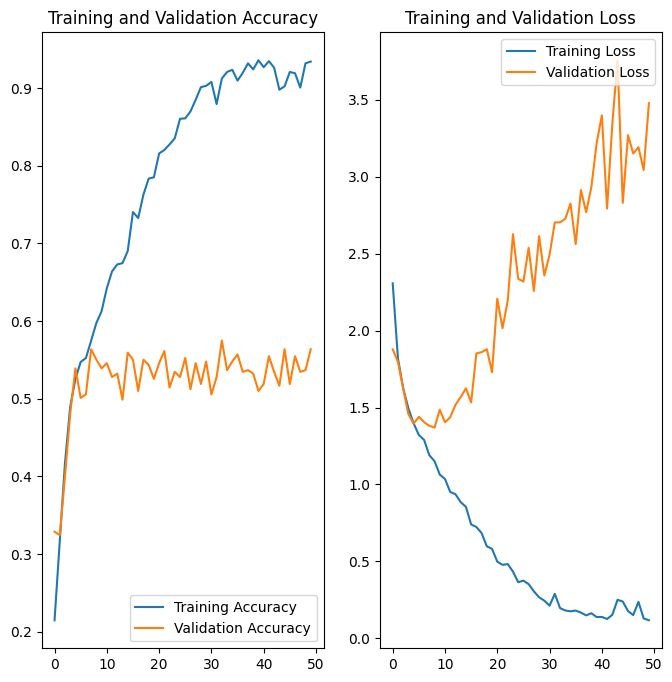

In [60]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

Augmentor allows us to create an augmentation pipeline, which chains together operations that are applied stochastically, where the parameters of each of these operations are also chosen at random, within a range specified by the user. This means that each time an image is passed through the pipeline, a different image is returned. Depending on the number of operations in the pipeline, and the range of values that each operation has available, a very large amount of new image data can be created in this way.

The balancing of each class using Augmentor has helped to improve the performance of the model drastically. We can see from the plot that both training and validation accuracy increases steadily. Final accuracy achieved for training set is ~94% and validation set is ~80%. We can also infer that Augmentation also helped to control the initial overfitting issue.

In [61]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_test,
  labels='inferred',
  label_mode='int',
  batch_size=32,
  class_names=None,
  color_mode='rgb',
  image_size=(img_height, img_width),
  seed=123,
  shuffle=False,
  interpolation='bilinear',
  follow_links=False)

Found 118 files belonging to 9 classes.


In [62]:
img_path = '/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Test/melanoma/ISIC_0000036.jpg'
img = keras.preprocessing.image.load_img(
    img_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
print('Predictions:- ',predictions)

score = tf.nn.relu(predictions[0])
print('Score:- ',score)
print("This image most likely belongs to {} with a {:.2f} prediction score."
    .format(class_names[np.argmax(score)], np.max(score))
)

1/1 [==============================] - 0s 236ms/step
Predictions:-  [[ -7.576805  10.093396 -56.405384  37.709747  38.883186  29.321825
    7.767987 -46.504963 -23.826494]]
Score:-  tf.Tensor(
[ 0.       10.093396  0.       37.709747 38.883186 29.321825  7.767987
  0.        0.      ], shape=(9,), dtype=float32)
This image most likely belongs to nevus with a 38.88 prediction score.
